In [1]:
import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader

from torchdyn.core import NeuralODE

import matplotlib.pyplot as plt
import pickle


# Data Generation

In [2]:
def damped_harmonic_oscillator(x0, v0, m, k, c, t_max=10, dt=0.1):
    """
    Simulate the trajectory of a damped harmonic oscillator
    simple newton method solver

    Args:
        x0 (float): Initial position
        v0 (float): Initial velocity
        m (float): Mass
        k (float): Spring constant
        c (float): Viscous force coefficient
        t_max (float, optional): Maximum time to simulate (default: 10)
        dt (float, optional): Time step (default: 0.01)

    Returns:
        numpy.ndarray: Array of position values
        numpy.ndarray: Array of time values
    """
    t = np.arange(0, t_max, dt)
    x = np.zeros_like(t)
    v = np.zeros_like(t)

    x[0] = x0
    v[0] = v0

    for i in range(1, len(t)):
        a = -c * v[i-1] / m - k * x[i-1] / m  # Acceleration
        v[i] = v[i-1] + a * dt  # Update velocity
        x[i] = x[i-1] + v[i-1] * dt  # Update position

    return x, t

def get_damping_zone(m,k,c):
    zeta = c / (2 * np.sqrt(k * m))
    if zeta > 1:
        return "over-damped"
    if zeta == 1:
        return "critically damped"
    if zeta < 1:
        return "under-damped"

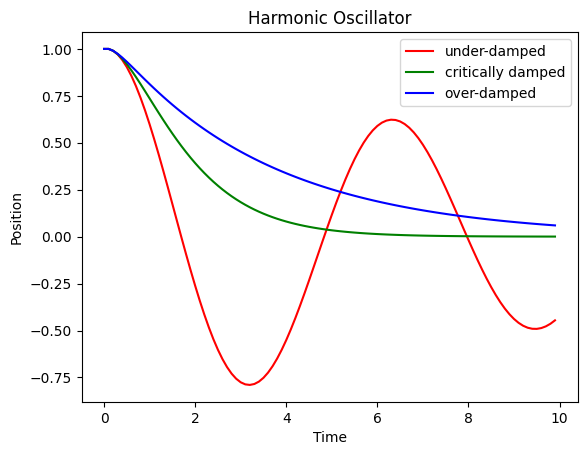

In [3]:
# for simplicity just have it produce trajectories across a range of viscosities
# this is the only conditioned augmented dimension for the proof of concept

x0 = 1.0  # Initial position
v0 = 0.0  # Initial velocity
m = 1.0   # Mass
k = 1.0   # Spring constant
c = np.array([0.25, 2, 3.75]) # np.arange(0.25,5.25,0.25)   # Viscous force coefficient
t_max = 10

X = []
T = [] # same for all unnecessary
labels = []


for ci in c:
    xi,ti = damped_harmonic_oscillator(x0, v0, m, k, ci, t_max)
    labeli = get_damping_zone(m,k,ci)
    X.append(xi)
    T.append(ti)
    labels.append(labeli)


colors = ['red', 'green', 'blue']
for i, x in enumerate(X):
    labeli = labels[i]
    plt.plot(T[i], x, label=labeli, color=colors[i])

# for i, x in enumerate(X):
#     labeli = labels[i]
#     plt.plot(T[i], x, label=labeli)
plt.xlabel('Time')
plt.ylabel('Position')
plt.title(f'Harmonic Oscillator')
plt.legend()
plt.show()

In [4]:
# Create "HADM_ID" column to label the three distinct oscillation groups
hadm_id = [1]*100 + [2]*100 + [3]*100  # Repeats 1, 2, and 3, each 100 times

# Scale time values T to range between 0 and 1
T = [t/10 for t in T]

# # Identify indices where oscillation changes (i.e., where HADM_ID changes)
# end_pt_indices = torch.nonzero(hadm_id[1:] != hadm_id[:-1], as_tuple=False).squeeze() + 1

# Create a DataFrame with the relevant columns
# for this dataset, normalization of x is skipped
df = pd.DataFrame({
    'HADM_ID': hadm_id,
    'x': torch.tensor(np.concatenate(X), dtype=torch.float32).numpy(),
    'c': torch.tensor(c).repeat_interleave(100).type(torch.float32).numpy(),
    't': torch.tensor(np.concatenate(T), dtype=torch.float32).numpy()
})

# # Prepare data dictionary for PyTorch Lightning
# # for this overfitting demo, using the same data for train/val/test
df_all = {'train': df, 'val': df, 'test': df}

file_path = "3Oscillation_data.pkl"
with open(file_path, 'wb') as f:
    pickle.dump(df_all, f)

# Dataloader

In [5]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

class TrainingDataset(Dataset):
    def __init__(self, x0_values, x0_classes, x1_values, times_x0, times_x1):
        self.x0_values = x0_values
        self.x0_classes = x0_classes
        self.x1_values = x1_values
        self.times_x0 = times_x0
        self.times_x1 = times_x1

    def __len__(self):
        return len(self.x0_values)

    def __getitem__(self, idx):
        return (self.x0_values[idx], self.x0_classes[idx], self.x1_values[idx], self.times_x0[idx], self.times_x1[idx])


class PatientDataset(Dataset):
    def __init__(self, patient_data):
        self.patient_data = patient_data

    def __len__(self):
        return len(self.patient_data)

    def __getitem__(self, idx):
        return self.patient_data[idx]


class eICUDataLoader:
    def __init__(self, 
                 file_path, 
                 t_headings,
                 x_headings,
                 cond_headings,
                 memory = 0,
                 batch_size=256, 
                 groupby = 'HADM_ID',
                 train_consecutive=False):
        
        self.batch_size = batch_size
        self.file_path = file_path
        self.x_headings = x_headings
        self.cond_headings = cond_headings
        self.t_headings = t_headings
        self.input_dim = len(self.x_headings) + len(self.cond_headings)
        self.output_dim = len(self.x_headings)
        self.memory = memory
        self.min_timept = 5 + self.memory
        self.train_consecutive = train_consecutive
        self.groupby = groupby

        # Load and setup data
        self.data = pd.read_pickle(self.file_path)
        self.train_data = self.__filter_data(self.data['train'])
        self.val_data = self.__filter_data(self.data['val'])
        self.test_data = self.__filter_data(self.data['test'])

    def __filter_data(self, data_set):
        return data_set.groupby(self.groupby).filter(lambda x: len(x) > self.min_timept)

    def __unpack__(self, data_set):
        x = data_set[self.x_headings].values
        cond = data_set[self.cond_headings].values
        t = data_set[self.t_headings].values
        return x, cond, t
    
    def __sort_group__(self, data_set):
        grouped = data_set.groupby(self.groupby)
        grouped_sorted = grouped.apply(lambda x: x.sort_values([self.t_headings], ascending=True)).reset_index(drop=True)
        return grouped_sorted

    def create_pairs(self, df):
        x0_values = []
        x0_classes = []
        x1_values = []
        times_x0 = []
        times_x1 = []

        for _, group in df.groupby(self.groupby):
            sorted_group = group.sort_values(by=self.t_headings)

            for i in range(self.memory, len(sorted_group) - 1):
                x0 = sorted_group.iloc[i]
                x0_class = x0[self.cond_headings].values
                x0_value = x0[self.x_headings].values

                x1 = sorted_group.iloc[i + 1]
                x1_value = x1[self.x_headings].values

                if self.memory > 0:
                    x0_memory = sorted_group.iloc[i - self.memory:i]
                    x0_memory_flatten = x0_memory[self.x_headings].values.flatten()
                    x0_class = np.append(x0_class, x0_memory_flatten)

                x0_values.append(x0_value)
                x0_classes.append(x0_class)
                x1_values.append(x1_value)
                times_x0.append(x0[self.t_headings])
                times_x1.append(x1[self.t_headings])

        x0_values = np.array(x0_values).squeeze().astype(np.float32)
        x0_classes = np.array(x0_classes).squeeze().astype(np.float32)
        x1_values = np.array(x1_values).squeeze().astype(np.float32)
        times_x0 = np.array(times_x0).squeeze().astype(np.float32)
        times_x1 = np.array(times_x1).squeeze().astype(np.float32)

        # if ==0, shape of (bs, 0) will be kept; 
        # if >=2, shape of (bs, cond_num+dim*memory) will be kept
        if len(self.cond_headings) + self.memory == 1: 
            x0_classes = np.expand_dims(x0_classes, axis=1)
        
        if len(self.x_headings) < 2:
            x0_values = np.expand_dims(x0_values, axis=1)
            x1_values = np.expand_dims(x1_values, axis=1)

        return x0_values, x0_classes, x1_values, times_x0, times_x1

    def create_patient_data(self, df):
        patient_lst = []
        for _, group in df.groupby(self.groupby):
            sorted_group = group.sort_values(by=self.t_headings)
            x0_values, x0_classes, x1_values, times_x0, times_x1 = self.create_pairs(sorted_group)

            patient_lst.append((x0_values,
                                x0_classes,
                                x1_values,
                                times_x0,
                                times_x1))
        return patient_lst

    def create_patient_data_t0(self, df):
        patient_lst = []
        for _, group in df.groupby(self.groupby):
            sorted_group = group.sort_values(by=self.t_headings)
            x0_values, x0_classes, x1_values, times_x0, times_x1 = self.create_pairs(sorted_group)

            if len(self.cond_headings) < 2:
                x0_classes = np.expand_dims(x0_classes, axis=1)
            else:
                x0_classes = x0_classes.squeeze().astype(np.float32)

            x0_values = np.repeat(x0_values[0][None, :], len(x0_values), axis=0)
            x0_classes = np.repeat(x0_classes[0][None, :], len(x0_values), axis=0)
            times_x0 = np.repeat(times_x0[0], len(x0_values))

            patient_lst.append((x0_values.squeeze().astype(np.float32),
                                x0_classes,
                                x1_values.squeeze().astype(np.float32),
                                times_x0.squeeze().astype(np.float32),
                                times_x1.squeeze().astype(np.float32)))
        return patient_lst

    def get_dataloader(self, data, shuffle=True, for_training=True):
        if for_training and self.train_consecutive:
            data = self.create_patient_data_t0(data)
            dataset = PatientDataset(data)
            return DataLoader(dataset, batch_size=1, shuffle=shuffle, num_workers=0)
        elif for_training:
            data = self.create_pairs(data)
            dataset = TrainingDataset(*data)
            return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle, num_workers=0)
        else:
            data = self.create_patient_data(data)
            dataset = PatientDataset(data)
            return DataLoader(dataset, batch_size=1, shuffle=shuffle, num_workers=0)

    def get_train_loader(self, shuffle=True):
        return self.get_dataloader(self.train_data, shuffle=shuffle, for_training=True)

    def get_val_loader(self):
        return self.get_dataloader(self.val_data, shuffle=False, for_training=False)

    def get_test_loader(self):
        return self.get_dataloader(self.test_data, shuffle=False, for_training=False)

# Model

In [ ]:
class torch_wrapper_tv(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


class SDE(torch.nn.Module):

    noise_type = "diagonal"
    sde_type = "ito"

    # noise is sigma in this notebook for the equation sigma * (t * (1 - t))
    def __init__(self, ode_drift, noise=1.0, reverse=False):
        super().__init__()
        self.drift = ode_drift
        self.reverse = reverse
        self.noise = noise

    # Drift
    def f(self, t, y):
        if self.reverse:
            t = 1 - t
        if len(t.shape) == len(y.shape):
            x = torch.cat([y, t], 1)
        else:
            x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
        return self.drift(x)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(t) * torch.ones_like(y) * self.noise


class SDE_func_solver(torch.nn.Module):

    noise_type = "diagonal"
    sde_type = "ito"

    # noise is sigma in this notebook for the equation sigma * (t * (1 - t))
    def __init__(self, ode_drift, noise, reverse=False):
        super().__init__()
        self.drift = ode_drift
        self.reverse = reverse
        self.noise = noise # changeable, a model itself

    # Drift
    def f(self, t, y):
        if self.reverse:
            t = 1 - t
        if len(t.shape) == len(y.shape):
            x = torch.cat([y, t], 1)
        else:
            x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
        return self.drift(x)

    # Diffusion
    def g(self, t, y):
        if self.reverse:
            t = 1 - t
        if len(t.shape) == len(y.shape):
            x = torch.cat([y, t], 1)
        else:
            x = torch.cat([y, t.repeat(y.shape[0])[:, None]], 1)
        noise_result = self.noise(x)
        return noise_result* torch.sqrt(t * (1 - t))
    

def metrics_calculation(pred, true, metrics=['mse_loss'], cutoff=-0.91, map_idx = 1):
    
    # if pred is a tensor, convert to numpy
    if isinstance(pred, torch.Tensor):
        pred = pred.detach().cpu().squeeze().numpy()
        true = true.detach().cpu().squeeze().numpy()

    loss_D = {key : None for key in metrics}
    for metric in metrics:
        if metric == 'mse_loss':
            loss_D['mse_loss'] = np.mean((pred - true)**2)
            # self.log('mse_loss', self.loss_fn(pred, true))
        if metric == 'l1_loss':
            loss_D['l1_loss'] = np.mean(np.abs(pred - true))
            # self.log('l1_loss', torch.mean(torch.abs(pred - true)))

    return loss_D

In [6]:
import torch
import math
import time

import matplotlib.pyplot as plt
import numpy as np
from torchdyn.core import NeuralODE
from torch import optim
import torch.functional as F


PE_BASE = 0.012 # 0.012615662610100801
NUM_FREQS = 10

def positional_encoding_tensor(time_tensor, num_frequencies=NUM_FREQS, base=PE_BASE):
    # Ensure the time tensor is in the range [0, 1]
    time_tensor = time_tensor.clamp(0, 1).unsqueeze(1)  # Clamp and add dimension for broadcasting

    # Compute the arguments for the sine and cosine functions using the custom base
    frequencies = torch.pow(base, -torch.arange(0, num_frequencies, dtype=torch.float32) / num_frequencies)
    angles = time_tensor * frequencies

    # Compute the sine and cosine for even and odd indices respectively
    sine = torch.sin(angles)
    cosine = torch.cos(angles)

    # Stack them along the last dimension
    pos_encoding = torch.stack((sine, cosine), dim=-1)
    pos_encoding = pos_encoding.flatten(start_dim=2)

    # Normalize to have values between 0 and 1
    pos_encoding = (pos_encoding + 1) / 2  # Now values are between 0 and 1
    
    return pos_encoding

class MLP_conditional_memory(torch.nn.Module):
    """ Conditional with many available classes

    return the class as is
    """
    def __init__(self, 
                 dim, 
                 treatment_cond,
                 memory, # how many time steps
                 out_dim=None, 
                 w=64, 
                 time_varying=False, 
                 conditional=False,  
                 time_dim = NUM_FREQS * 2,
                 clip = None,
                 ):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            self.out_dim = dim 
        self.out_dim += 1 # for the time dimension
        self.treatment_cond = treatment_cond
        self.memory = memory
        self.dim = dim
        self.indim = dim + (time_dim if time_varying else 0) + (self.treatment_cond if conditional else 0) + (dim * memory)
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.indim, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w,self.out_dim),
        )
        self.default_class = 0
        self.clip = clip

    def encoding_function(self, time_tensor):
        return positional_encoding_tensor(time_tensor)    

    def forward_train(self, x):
        """forward pass
        Assume first two dimensions are x, c, then t
        """
        time_tensor = x[:,-1]
        encoded_time_span = self.encoding_function(time_tensor).reshape(-1, NUM_FREQS * 2)
        new_x = torch.cat([x[:,:-1], encoded_time_span], dim=1)
        result = self.net(new_x)
        return torch.cat([result[:,:-1], x[:,self.dim:-1], result[:,-1].unsqueeze(1)], dim=1)

    def forward(self, x):
        """ call forward_train for training
            x here is x_t
            xt = (t)x1 + (1-t)x0
            (xt - tx1)/(1-t) = x0
        """
        x1 = self.forward_train(x)
        x1_coord = x1[:,:self.dim]
        t = x[:,-1]
        pred_time_till_t1 = x1[:,-1]
        x_coord = x[:,:self.dim]
        if self.clip is None:
            vt = (x1_coord - x_coord)/(pred_time_till_t1)
        else:
            vt = (x1_coord - x_coord)/torch.clip((pred_time_till_t1),min=self.clip)

        final_vt = torch.cat([vt, torch.zeros_like(x[:,self.dim:-1])], dim=1)
        return final_vt

class MLP_conditional_memory_sde_noise(torch.nn.Module):
    """ Conditional with many available classes

    return the class as is
    """
    def __init__(self, 
                 dim, 
                 treatment_cond,
                 memory, # how many time steps
                 out_dim=None, 
                 w=64, 
                 time_varying=False, 
                 conditional=False,  
                 time_dim = NUM_FREQS * 2,
                 clip = None,
                 ):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            self.out_dim = 1 # for noise 
        self.treatment_cond = treatment_cond
        self.memory = memory
        self.dim = dim
        self.indim = dim + (time_dim if time_varying else 0) + (self.treatment_cond if conditional else 0) + (dim * memory)
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.indim, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w,self.out_dim),
        )
        self.default_class = 0
        self.clip = clip

    def encoding_function(self, time_tensor):
        return positional_encoding_tensor(time_tensor)    

    def forward_train(self, x):
        """forward pass
        Assume first two dimensions are x, c, then t
        """
        time_tensor = x[:,-1]
        encoded_time_span = self.encoding_function(time_tensor).reshape(-1, NUM_FREQS * 2)
        new_x = torch.cat([x[:,:-1], encoded_time_span], dim=1)
        result = self.net(new_x)
        return result
    
    def forward(self,x):
        result = self.forward_train(x)
        return torch.cat([result, torch.zeros_like(x[:,1:-1])], dim=1)

def mse_loss(pred, true):
    return torch.mean((pred - true) ** 2)

class Noise_MLP_Cond_Memory_Module(torch.nn.Module):
    def __init__(self, treatment_cond, memory=3, dim=2, w=64, time_varying=True, conditional=True, lr=1e-6, sigma=0.1, 
                 loss_fn=mse_loss, metrics=['mse_loss', 'l1_loss'], implementation="ODE", sde_noise=0.1, clip=None, naming=None):
        super().__init__()
        self.flow_model = MLP_conditional_memory(dim=dim, w=w, time_varying=time_varying, conditional=conditional, 
                                                 treatment_cond=treatment_cond, memory=memory, clip=clip)
        if implementation == "SDE":
            self.noise_model = MLP_conditional_memory_sde_noise(dim=dim, w=w, time_varying=time_varying, conditional=conditional, 
                                                                treatment_cond=treatment_cond, memory=memory, clip=clip)
        else:
            self.noise_model = MLP_conditional_memory(dim=dim, w=w, time_varying=time_varying, conditional=conditional, 
                                                      treatment_cond=treatment_cond, memory=memory, clip=clip)
        self.loss_fn = loss_fn
        self.dim = dim
        self.w = w
        self.time_varying = time_varying
        self.conditional = conditional
        self.treatment_cond = treatment_cond
        self.lr = lr
        self.sigma = sigma
        self.metrics = metrics
        self.implementation = implementation
        self.memory = memory
        self.sde_noise = sde_noise
        self.clip = clip

    def forward(self, x):
        return self.flow_model(x)

    def configure_optimizers(self):
        flow_optimizer = torch.optim.Adam(self.flow_model.parameters(), lr=self.lr)
        noise_optimizer = torch.optim.Adam(self.noise_model.parameters(), lr=self.lr)
        return flow_optimizer, noise_optimizer

    def __convert_tensor__(self, tensor):
        return tensor.to(torch.float32)

    def __x_processing__(self, x0, x1, t0, t1):
        t = torch.rand(x0.shape[0], 1).to(x0.device)
        mu_t = x0 * (1 - t) + x1 * t
        data_t_diff = (t1 - t0).unsqueeze(1)
        x = mu_t + self.sigma * torch.randn(x0.shape[0], self.dim).to(x0.device)
        ut = (x1 - x0) / (data_t_diff + 1e-4)
        t_model = t * data_t_diff + t0.unsqueeze(1)
        futuretime = t1 - t_model
        return x, ut, t_model, futuretime, t

class MLP_Cond_Memory_Module(torch.nn.Module):
    def __init__(self, treatment_cond, memory=3, dim=2, w=64, time_varying=True, conditional=True, lr=1e-6, sigma=0.1, 
                 loss_fn=mse_loss, metrics=['mse_loss', 'l1_loss'], implementation="ODE", sde_noise=0.1, clip=None, naming=None):
        super().__init__()
        self.model = MLP_conditional_memory(dim=dim, w=w, time_varying=time_varying, conditional=conditional, 
                                            treatment_cond=treatment_cond, memory=memory, clip=clip)
        self.loss_fn = loss_fn
        self.dim = dim
        self.w = w
        self.time_varying = time_varying
        self.conditional = conditional
        self.treatment_cond = treatment_cond
        self.lr = lr
        self.sigma = sigma
        self.metrics = metrics
        self.implementation = implementation
        self.memory = memory
        self.sde_noise = sde_noise
        self.clip = clip

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer

    def __convert_tensor__(self, tensor):
        return tensor.to(torch.float32)

    def __x_processing__(self, x0, x1, t0, t1):
        t = torch.rand(x0.shape[0], 1).to(x0.device)
        mu_t = x0 * (1 - t) + x1 * t
        data_t_diff = (t1 - t0).unsqueeze(1)
        x = mu_t + self.sigma * torch.randn(x0.shape[0], self.dim).to(x0.device)
        ut = (x1 - x0) / (data_t_diff + 1e-4)
        t_model = t * data_t_diff + t0.unsqueeze(1)
        futuretime = t1 - t_model
        return x, ut, t_model, futuretime, t


In [7]:
def train_model(model, noise_prediction, train_loader, val_loader=None, num_epochs=10, device='cuda'):
    model.to(device)

    # with noise prediction
    if noise_prediction: 
        flow_optimizer, noise_optimizer = model.configure_optimizers()
    # without noise prediction
    else: 
        optimizer = model.configure_optimizers()

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            x0, x0_class, x1, x0_time, x1_time = [b.to(device) for b in batch]

            x, ut, t_model, futuretime, t = model.__x_processing__(x0, x1, x0_time, x1_time)

            in_tensor = torch.cat([x, x0_class, t_model], dim=-1)

            # with noise prediction
            if noise_prediction: 
                xt = model.model.flow_model.forward_train(in_tensor)

                if model.implementation == "SDE":
                    sde_noise = model.noise_model.forward_train(in_tensor)
                    variance = torch.sqrt(t * (1 - t)) * sde_noise
                    noise = torch.randn_like(xt[:, :model.dim]) * variance
                    loss = model.loss_fn(xt[:, :model.dim] + noise.clone().detach(), x1) + model.loss_fn(xt[:, -1], futuretime)
                    uncertainty = (xt[:, :model.dim].clone().detach() + noise)
                    noise_loss = model.loss_fn(uncertainty, x1)
                else:
                    loss = model.loss_fn(xt[:, :model.dim], x1) + model.loss_fn(xt[:, -1], futuretime)
                    uncertainty = torch.abs(xt[:, :model.dim].clone().detach() - x1)
                    noise_loss = model.loss_fn(model.noise_model.forward_train(in_tensor)[:, :model.dim], uncertainty)

                flow_optimizer.zero_grad()
                loss.backward()
                flow_optimizer.step()

                noise_optimizer.zero_grad()
                noise_loss.backward()
                noise_optimizer.step()

                train_loss += (loss + noise_loss).item()

            # without noise prediction
            else: 
                xt = model.model.forward_train(in_tensor)

                if model.implementation == "SDE":
                    variance = t * (1 - t) * model.sde_noise
                    noise = torch.randn_like(xt[:, :model.dim]) * torch.sqrt(variance)
                    loss = model.loss_fn(xt[:, :model.dim] + noise, x1) # + model.loss_fn(xt[:, -1], futuretime)
                else:
                    loss = model.loss_fn(xt[:, :model.dim], x1) # + model.loss_fn(xt[:, -1], futuretime)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

        # validation
        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader)}")
            if val_loader: 
                test_model(model, noise_prediction, val_loader, device)

In [8]:
def test_model(model, noise_prediction, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    list_of_pairs = []
    list_of_times = []

    dict_full_trajs = {}
    dict_pred_trajs = {}

    loss_sum = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            batch = [x.to(device) for x in batch]
            loss, pairs, metricD, noise_loss, noise_pair, full_time = test_func_step(batch, batch_idx, model, noise_prediction)
            list_of_pairs.append(pairs)
            list_of_times.append(full_time)
            full_traj = pairs[0][0]
            pred_traj = pairs[0][1]
            dict_full_trajs[batch_idx] = full_traj.detach().cpu().numpy()
            dict_pred_trajs[batch_idx] = pred_traj.detach().cpu().numpy()
            loss_sum += loss

        fig = plt.figure(figsize=(5, 4))
        ax = fig.add_subplot(111)
        colors = ['red', 'green', 'blue']
        T = np.arange(0,1,0.01)
        count = 0
        for _,v in dict_pred_trajs.items():
            ax.plot(T[model.memory:], v, label="predicted" if count == 0 else '', color=colors[count])
            count += 1
        count = 0
        for _,v in dict_full_trajs.items():
            ax.plot(T[model.memory:], v, label="ground truth" if count == 0 else '', color=colors[count], linestyle='--')
            count += 1

        ax.set_xlabel('scaled t', fontsize='10')
        ax.set_ylabel('x', fontsize='10')
        # ax.set_title("damped_oscillations_epoch_{}".format(self.current_epoch))
        ax.legend(fontsize='10')
        plt.tight_layout()
        plt.show()
        plt.close()
    print(f"validation loss: {loss_sum/len(test_loader)}")

def test_func_step(batch, batch_idx, model, noise_prediction):
    """Assuming each batch is one patient"""
    total_loss = []
    traj_pairs = []

    total_noise_loss = []
    noise_pairs = []

    x0_values, x0_classes, x1_values, times_x0, times_x1 = batch
    times_x0 = times_x0.squeeze()
    times_x1 = times_x1.squeeze()

    full_traj = torch.cat([x0_values[0, 0, :model.dim].unsqueeze(0), x1_values[0, :, :model.dim]], dim=0)
    full_time = torch.cat([times_x0[0].unsqueeze(0), times_x1], dim=0)
    # print(f"full_traj {full_traj.shape}")
    # print(f"full_time {full_time.shape}")

    if model.implementation == "ODE":
        ind_loss, pred_traj, noise_mse, noise_pred = test_trajectory_ode(batch, model, noise_prediction)
    elif model.implementation == "SDE":
        ind_loss, pred_traj, noise_mse, noise_pred = test_trajectory_sde(batch, model, noise_prediction)

    # print(f"pred_traj {pred_traj.shape}")

    total_loss.append(ind_loss)
    traj_pairs.append([full_traj, pred_traj])
    noise_pairs.append([full_traj, noise_pred])
    total_noise_loss.append(noise_mse)

    # Optionally detach and move tensors to CPU for further processing or visualization
    full_traj = full_traj.detach().cpu().numpy()
    pred_traj = pred_traj.detach().cpu().numpy()
    full_time = full_time.detach().cpu().numpy()

    # # Generate the plot
    # fig = plot_3d_path_ind_noise(pred_traj, full_traj, noise_pred, t_span=full_time, title=f"trajectory_patient_{batch_idx}")
    
    # plt.close(fig)

    # Calculate metrics
    metricD = metrics_calculation(pred_traj, full_traj)
    return np.mean(total_loss), traj_pairs, metricD, np.mean(total_noise_loss), noise_pairs, full_time
    
def test_trajectory_ode(batch, model, noise_prediction): # have to squeeze here to adjust for bs=1
    # with noise prediction
    
    if noise_prediction:
        node = NeuralODE(torch_wrapper_tv(model.flow_model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        node_noise = NeuralODE(torch_wrapper_tv(model.noise_model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    else:
        node = NeuralODE(torch_wrapper_tv(model.model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    total_pred, noise_pred = [], []
    mse, noise_mse = [], []
    total_pred = []
    mse = []

    x0_values, x0_classes, x1_values, times_x0, times_x1 = batch
    # print("="*10)
    # print("HERE test_trajectory ode")
    # print(f"x0 from dataloader {x0_values.shape}")
    # print(f"cond from dataloader {x0_classes.shape}")
    # print(f"x1 from dataloader {x1_values.shape}")
    # print(f"t0 from dataloader {times_x0.shape}")
    # print(f"t1 from dataloader {times_x1.shape}")
    # print(f"t0[0] {times_x0[0].shape}")
    # print(f"t1[0] {times_x1[0].shape}")
    # print(f"history {x0_classes[0][-(model.memory * model.dim):].shape}")
    # print(f"x0_values.shape[0] {x0_values.shape[0]}")
    # print(f"x1_values.shape[0] {x1_values.shape[0]}")
    x0_values = x0_values.squeeze(0)
    x0_classes = x0_classes.squeeze(0)
    x1_values = x1_values.squeeze(0)
    times_x0 = times_x0.squeeze()
    times_x1 = times_x1.squeeze()
    # print(f"x0 squeezed {x0_values.shape}")
    # print(f"cond squeezed {x0_classes.shape}")
    # print(f"x1 squeezed {x1_values.shape}")
    # print(f"t0 squeezed {times_x0.shape}")
    # print(f"t1 squeezed {times_x1.shape}")

    total_pred.append(x0_values[0].unsqueeze(0))
    len_path = x0_values.shape[0]
    # assert len_path == x1_values.shape[0]

    if model.memory > 0:
        time_history = x0_classes[0][-(model.memory * model.dim):]

    for i in range(len_path):
        time_span = torch.linspace(times_x0[i], times_x1[i], 10).to(x0_values.device)

        # print("-"*10)
        # print(f"i {i}")

        if model.memory > 0:
            # print(f"cond memory>0 part 1 shape {x0_classes[i][:-(model.memory * model.dim)].unsqueeze(0).shape}")
            # print(f"cond memory>0 part 1 {x0_classes[i][:-(model.memory * model.dim)].unsqueeze(0)}")
            # print(f"cond memory>0 part 2 shape {time_history.unsqueeze(0).shape}")
            # print(f"cond memory>0 part 2 {time_history.unsqueeze(0)}")
            new_x_classes = torch.cat([x0_classes[i][:-(model.memory * model.dim)].unsqueeze(0), time_history.unsqueeze(0)], dim=1)
            # print(new_x_classes.shape)
            # print(x0_classes[i].shape)
        else:
            new_x_classes = x0_classes[i].unsqueeze(0)
            # print(f"cond memory=0 {new_x_classes.shape}")

        with torch.no_grad():
            if i == 0: # TODO: here is the issue to fix. Seems to be wrong for the paper figure generation
                # testpt = torch.cat([x0_values[i].unsqueeze(0), new_x_classes], dim=1)
                testpt = torch.cat([x0_values[i].unsqueeze(0), x0_classes[i].unsqueeze(0)], dim=1)
                # print(f"testpt at i==0 {testpt.shape}")
            else:
                # testpt = torch.cat([pred_traj, new_x_classes], dim=1)
                testpt = torch.cat([pred_traj, x0_classes[i].unsqueeze(0)], dim=1)
                # print(f"testpt at i!=0 {testpt.shape}")
                
            traj = node.trajectory(testpt, t_span=time_span)
            if noise_prediction:
                noise_traj = node_noise.trajectory(testpt, t_span=time_span)

        pred_traj = traj[-1, :, :model.dim]
        total_pred.append(pred_traj)
        if noise_prediction:
            noise_traj = noise_traj[-1, :, :model.dim]
            noise_pred.append(noise_traj)
        

        ground_truth_coords = x1_values[i]
        mse_traj = model.loss_fn(pred_traj, ground_truth_coords).detach().cpu().numpy()
        mse.append(mse_traj)
        if noise_prediction:
            uncertainty_traj = ground_truth_coords - pred_traj
            noise_mse_traj = model.loss_fn(noise_traj, uncertainty_traj).detach().cpu().numpy()
            noise_mse.append(noise_mse_traj)

        
        if model.memory > 0:
            flattened_coords = pred_traj.flatten()
            time_history = torch.cat([time_history[model.dim:].unsqueeze(0), flattened_coords.unsqueeze(0)], dim=1).squeeze()

    mse_all = np.mean(mse)
    total_pred_tensor = torch.stack(total_pred).squeeze(1)
    if noise_prediction:
        noise_pred = torch.stack(noise_pred).squeeze(1)
    
    return mse_all, total_pred_tensor, noise_mse, noise_pred


def test_trajectory_sde(batch, model, noise_prediction):
    if noise_prediction:
        sde = SDE_func_solver(model.flow_model, noise=model.noise_model)
    else:
        sde = SDE(model.model, noise=0.1)
    total_pred, noise_pred = [], []
    mse, noise_mse = []

    x0_values, x0_classes, x1_values, times_x0, times_x1 = batch
    x0_values = x0_values.squeeze(0)
    x0_classes = x0_classes.squeeze(0)
    x1_values = x1_values.squeeze(0)
    times_x0 = times_x0.squeeze()
    times_x1 = times_x1.squeeze()

    # if len(x0_classes.shape) == 1:
    #     x0_classes = x0_classes.unsqueeze(1)

    total_pred.append(x0_values[0].unsqueeze(0))
    len_path = x0_values.shape[0]
    assert len_path == x1_values.shape[0]

    if model.memory > 0:
        time_history = x0_classes[0][-(model.memory * model.dim):]

    for i in range(len_path):
        time_span = torch.linspace(times_x0[i], times_x1[i], 10).to(x0_values.device)

        if model.memory > 0:
            new_x_classes = torch.cat([x0_classes[i][:-(model.memory * model.dim)].unsqueeze(0), time_history.unsqueeze(0)], dim=1)
        else:
            new_x_classes = x0_classes[i]

        with torch.no_grad():
            if i == 0:
                testpt = torch.cat([x0_values[i].unsqueeze(0), new_x_classes], dim=1)
            else:
                testpt = torch.cat([pred_traj, new_x_classes], dim=1)
                
            traj, noise_traj = _sde_solver(sde, testpt, time_span)

        pred_traj = traj[-1, :, :model.dim]
        noise_traj = noise_traj[-1, :, :model.dim]

        total_pred.append(pred_traj)
        if noise_prediction:
            noise_pred.append(noise_traj)

        ground_truth_coords = x1_values[i]
        mse_traj = model.loss_fn(pred_traj, ground_truth_coords).detach().cpu().numpy()
        mse.append(mse_traj)
        noise_mse.append(mse_traj)

        if model.memory > 0:
            flattened_coords = pred_traj.flatten()
            time_history = torch.cat([time_history[model.dim:].unsqueeze(0), flattened_coords.unsqueeze(0)], dim=1).squeeze()

    mse_all = np.mean(mse)
    noise_mse_all = np.mean(noise_mse)
    total_pred_tensor = torch.stack(total_pred).squeeze(1)
    if noise_prediction:
        noise_pred_tensor = torch.stack(noise_pred).squeeze(1)
    return mse_all, total_pred_tensor, noise_mse_all, noise_pred_tensor

def _sde_solver(sde, initial_state, time_span):
    dt = time_span[1] - time_span[0]
    current_state = initial_state
    trajectory = [current_state]
    noise_trajectory = []

    for t in time_span[1:]:
        drift = sde.f(t, current_state)
        diffusion = sde.g(t, current_state)
        noise = torch.randn_like(current_state) * torch.sqrt(dt)
        current_state = current_state + drift * dt + diffusion * noise
        trajectory.append(current_state)
        noise_trajectory.append(diffusion * noise)

    return torch.stack(trajectory), torch.stack(noise_trajectory)

# train experiments

In [13]:
data_loader_1d_3m = eICUDataLoader(batch_size=512, file_path=file_path, 
                             t_headings=['t'],
                             x_headings=['x'],
                             cond_headings=[],
                             memory=3)

train_loader_1d_3m = data_loader_1d_3m.get_train_loader(shuffle=True)
val_loader_1d_3m = data_loader_1d_3m.get_val_loader()

Epoch 100/1000, Loss: 0.0017163181910291314


/Users/yp325/.local/share/virtualenvs/clinical_trajectory-JXbBiG1u/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yp325/.local/share/virtualenvs/clinical_trajectory-JXbBiG1u/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


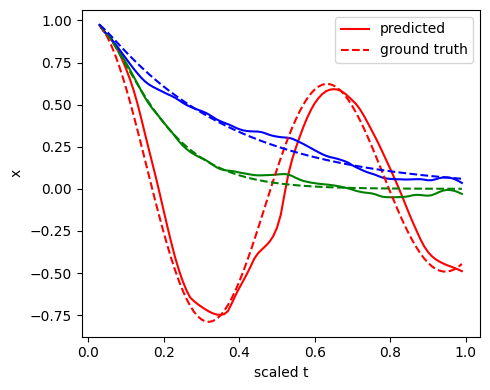

validation loss: 0.0056342807947658
Epoch 200/1000, Loss: 0.0009460448054596782


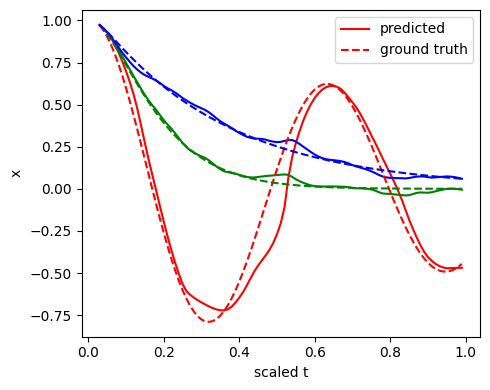

validation loss: 0.005433894043865924
Epoch 300/1000, Loss: 0.00040980230551213026


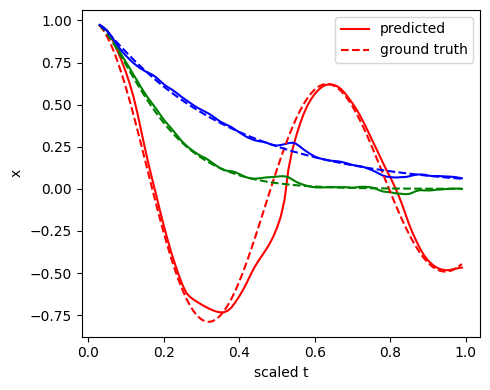

validation loss: 0.0039557587103142096
Epoch 400/1000, Loss: 0.00021682324586436152


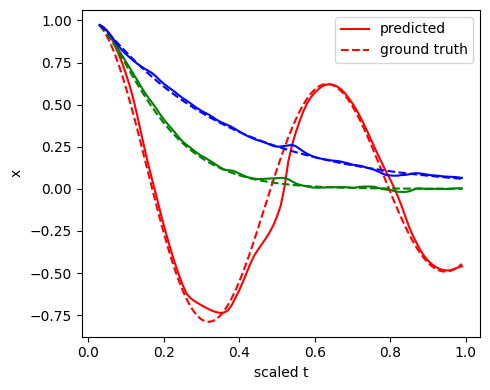

validation loss: 0.0023922913775701695
Epoch 500/1000, Loss: 0.00010523070523049682


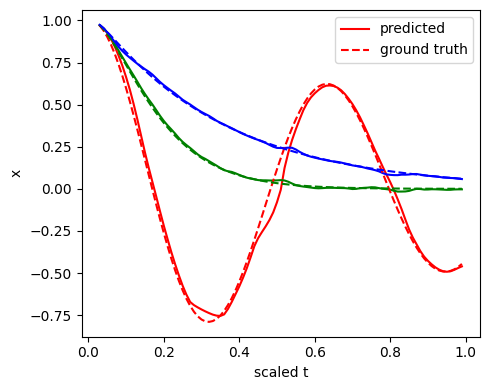

validation loss: 0.0010976505412448507
Epoch 600/1000, Loss: 5.629103907267563e-05


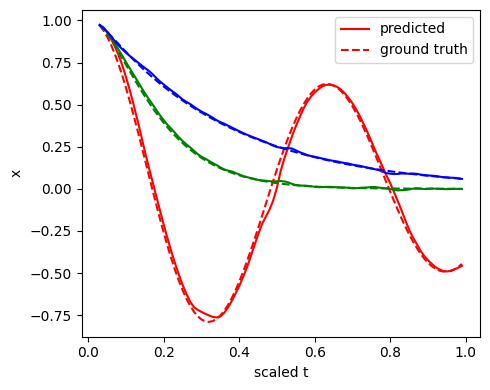

validation loss: 0.0005879542513866909
Epoch 700/1000, Loss: 0.00011325538071105257


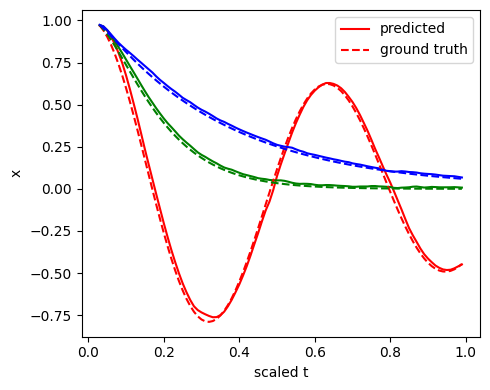

validation loss: 0.0006749724416295066
Epoch 800/1000, Loss: 3.578124596970156e-05


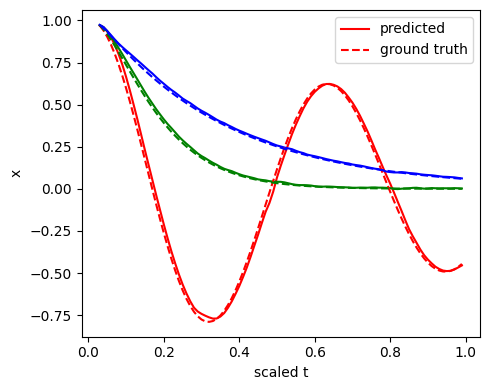

validation loss: 0.0005134563543833792
Epoch 900/1000, Loss: 5.232938565313816e-05


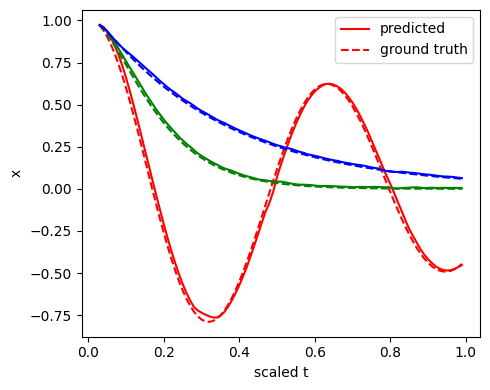

validation loss: 0.0005037291800059999
Epoch 1000/1000, Loss: 0.00016196101205423474


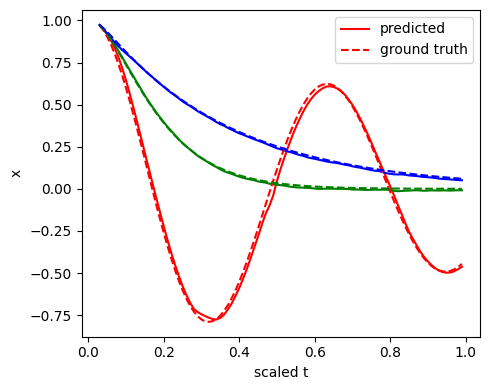

validation loss: 0.0004056398441510585


In [14]:
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Create the model instance
model = MLP_Cond_Memory_Module(treatment_cond=0, memory=3, 
                                     dim=1, w=256, 
                                     time_varying=True, 
                                     conditional=False, 
                                     lr=1e-3, 
                                     sigma=0.1, 
                                     loss_fn=mse_loss, 
                                     metrics=['mse_loss'], 
                                     implementation="ODE", 
                                     sde_noise=0.1, 
                                     clip=0.01)

# Train the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_model(model, False, train_loader_1d_3m, val_loader_1d_3m, num_epochs=1000, device=device)